# CTCF binding sites spatial distribution on Topological Domains

In [1]:
import pandas as pd
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt

figure_path = src.figures_path / "ctcfs_on_tads"
os.makedirs(figure_path, exist_ok=True)

cleanup()

In [2]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcfs_with_context.tsv", sep="\t")
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs[['orientation','context']], prefix="", prefix_sep="")), axis=1)
ctcfs = ctcfs.rename(columns={'>': 'forward', '<': 'reverse'})
ctcfs = ctcfs.merge(pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t"), on=src.coords + ['orientation'])
ctcfs.head()

,chr,start,end,orientation,context,reverse,forward,C,CD,D,S,T,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,T,0,1,0,0,0,0,1,0,9.790746,12.639115,1.502743e+09
1,chr1,521337,521697,>,S,0,1,0,0,0,1,0,1,10.259412,13.836791,1.680162e+09
2,chr1,714087,714447,>,S,0,1,0,0,0,1,0,2,9.893988,9.326291,1.342770e+09
3,chr1,805232,805362,>,S,0,1,0,0,0,1,0,3,14.365820,46.641218,3.446545e+09
4,chr1,839966,840326,>,S,0,1,0,0,0,1,0,4,16.393501,60.468042,3.756117e+09


## Using the initial complete set of TADs

In [3]:
all_TADs_by_celltype = pd.read_csv(src.interim_data_path / "all_TADs_by_celltype.tsv", sep="\t")
all_TADs_by_celltype.head()

,chr,start,end,tad_number,cell_type,tad_uid
0,chr1,1612500,1847500,0,Mon,Mon_0000
1,chr1,1646875,1842500,0,nB,nB_0000
2,chr1,1847500,2345000,0,Ery,Ery_0000
3,chr1,2112500,2342500,1,nB,nB_0001
4,chr1,2112500,2342500,0,Mac0,Mac0_0000


In [4]:
def windowing(all_TADs_by_celltype, n_windows=100, extension=0.1):
    tot_windows = n_windows + int(n_windows*extension)*2
    tad_start_window = int(n_windows*extension)
    tad_end_window = n_windows + int(n_windows*extension)
    
    windows = BedTool().window_maker(b=BedTool.from_dataframe(all_TADs_by_celltype).slop(l=0.1, r=0.1, pct=True, genome="hg19"), 
                                     n=tot_windows, i='srcwinnum')\
                       .to_dataframe(names=all_TADs_by_celltype.columns.tolist())
    idxs = windows.tad_uid.str.split("_", expand=True)
    tad_ids = idxs.iloc[:, :-1].apply(lambda x: "_".join(x), axis=1)
    w_nums = idxs.iloc[:, -1].astype(int) - 1
    windows[all_TADs_by_celltype.columns[-1]] = tad_ids
    windows['w_num'] = w_nums
    windows = windows.sort_values(src.coords).reset_index(drop=True)
    return windows, tad_start_window, tad_end_window

def coverage_by_window(windows, ctcfs, agg, null=0):
    cns = []
    c = []
    o = []
    for cn,v in agg.items():
        ci = ctcfs.columns.tolist().index(cn) + 1
        c.append(ci)
        cns.append(cn)
        o.append(v)
    windows_with_ctcfs = BedTool.from_dataframe(windows).map(BedTool.from_dataframe(ctcfs), c=c, o=o, null=null)\
                                .to_dataframe(names=windows.columns.tolist() + cns)
    return windows_with_ctcfs

### Compute the windows

In [5]:
n_windows = 100
extension = 0.1
windows, tad_start_window, tad_end_window = windowing(all_TADs_by_celltype[src.coords + ['tad_uid']], n_windows, extension)
windows.head()

,chr,start,end,tad_uid,w_num
0,chr1,1589000,1591350,Mon_0000,0
1,chr1,1591350,1593700,Mon_0000,1
2,chr1,1593700,1596050,Mon_0000,2
3,chr1,1596050,1598400,Mon_0000,3
4,chr1,1598400,1600750,Mon_0000,4


### Map CTCF sites in the windows

In [6]:
aggregations = {'ctcf_id': 'count', 
                'forward': 'sum', 
                'reverse': 'sum',
                'S': 'sum',
                'CD': 'sum', 
                'D': 'sum',
                'C': 'sum'}

windows_with_ctcfs = coverage_by_window(windows, ctcfs, aggregations)
windows_with_ctcfs.head()

,chr,start,end,tad_uid,w_num,ctcf_id,forward,reverse,S,CD,D,C
0,chr1,1589000,1591350,Mon_0000,0,1,0,1,0,0,0,1
1,chr1,1591350,1593700,Mon_0000,1,0,0,0,0,0,0,0
2,chr1,1593700,1596050,Mon_0000,2,0,0,0,0,0,0,0
3,chr1,1596050,1598400,Mon_0000,3,1,0,1,1,0,0,0
4,chr1,1598400,1600750,Mon_0000,4,0,0,0,0,0,0,0


In [7]:
aggregations_by_tad = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcfs.pivot_table(index='tad_uid', columns='w_num', values=c).sort_index(axis=1)
    cagg = cagg.sort_index(axis=1)
    aggregations_by_tad[c] = cagg 

### Observe the number of total CTCF sites VS number of forward and number of reverse CTCf sites

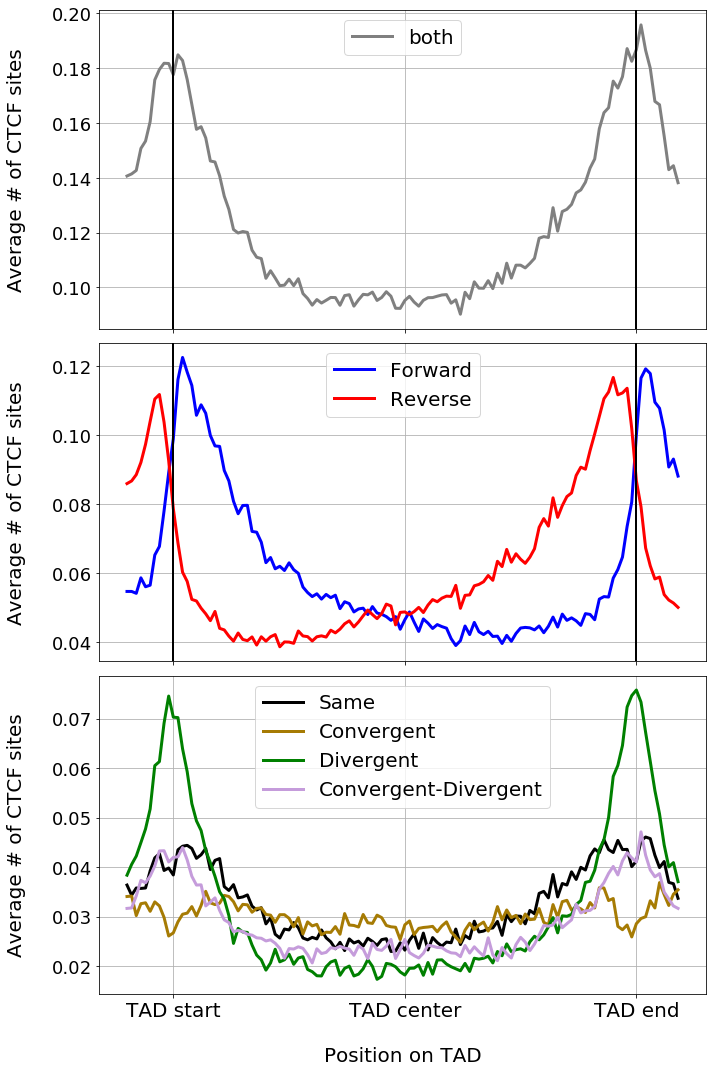

In [20]:
linewidth=3
legendfont = 20
labelfont = 20
tickfont = 20

fig, axes = plt.subplots(3,1,sharex=True,figsize=(10, 15))

axes[0].plot(aggregations_by_tad['ctcf_id'].mean(0), linewidth=linewidth, label='both', color='grey')
axes[0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
axes[0].axvline(tad_start_window, color='black')
axes[0].axvline(tad_end_window, color='black')
axes[0].grid()
axes[0].legend(loc='upper center', fontsize=legendfont)

axes[1].plot(aggregations_by_tad['forward'].mean(0), linewidth=linewidth, label='Forward', color='blue')
axes[1].plot(aggregations_by_tad['reverse'].mean(0), linewidth=linewidth, label='Reverse', color='red')
axes[1].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
axes[1].axvline(tad_start_window, color='black')
axes[1].axvline(tad_end_window, color='black')
axes[1].grid()
axes[1].legend(loc='upper center', fontsize=legendfont)

axes[2].plot(aggregations_by_tad['S'].mean(0), linewidth=linewidth, label='Same', color='black')
axes[2].plot(aggregations_by_tad['C'].mean(0), linewidth=linewidth, label='Convergent', color='#A67B04')
axes[2].plot(aggregations_by_tad['D'].mean(0), linewidth=linewidth, label='Divergent', color='green')
axes[2].plot(aggregations_by_tad['CD'].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#C59CDB')
axes[2].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
# axes[2].axvline(extension/resolution, color='black')
axes[2].grid()
axes[2].legend(loc='upper center', fontsize=legendfont)

axes[2].set_xticks([tad_start_window, int(tad_start_window + tad_end_window)/2 ,tad_end_window])
axes[2].set_xticklabels(['TAD start', 'TAD center', 'TAD end'], fontsize=tickfont)
axes[2].set_xlabel("\nPosition on TAD", fontsize=labelfont)

# plt.xticks([tad_start_window, int(tad_start_window + tad_end_window)/2 ,tad_end_window], 
#            labels=['TAD start', 'TAD center', 'TAD end'], fontsize=tickfont)
# plt.xlabel("\nPosition", fontsize=labelfont)
fig.savefig(figure_path / "avg_ctcf_sites_on_tads_by_window.pdf", bbox_inches='tight', transparent=True)
plt.show()

## Using the consensus TADs

In [11]:
window = 25000
minimum_conservation = 2
conserved_tads = pd.read_csv(src.interim_data_path / "consensus_tads" / "consensus_tads_w{}_min{}.tsv".format(window, minimum_conservation), sep="\t")
conserved_tads['tad_uid'] = list(range(conserved_tads.shape[0]))
conserved_tads.head()

,chr,start,end,tad_uid
0,chr1,10000,1842500,0
1,chr1,1847500,2112499,1
2,chr1,2112501,2342500,2
3,chr1,2350000,2724999,3
4,chr1,2725001,3355000,4


In [12]:
windows, tad_start_window, tad_end_window = windowing(conserved_tads, n_windows, extension)
windows_with_ctcfs = coverage_by_window(windows, ctcfs, aggregations)

In [13]:
aggregations_by_tad = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcfs.pivot_table(index='tad_uid', columns='w_num', values=c).sort_index(axis=1)
    cagg = cagg.sort_index(axis=1)
    aggregations_by_tad[c] = cagg 

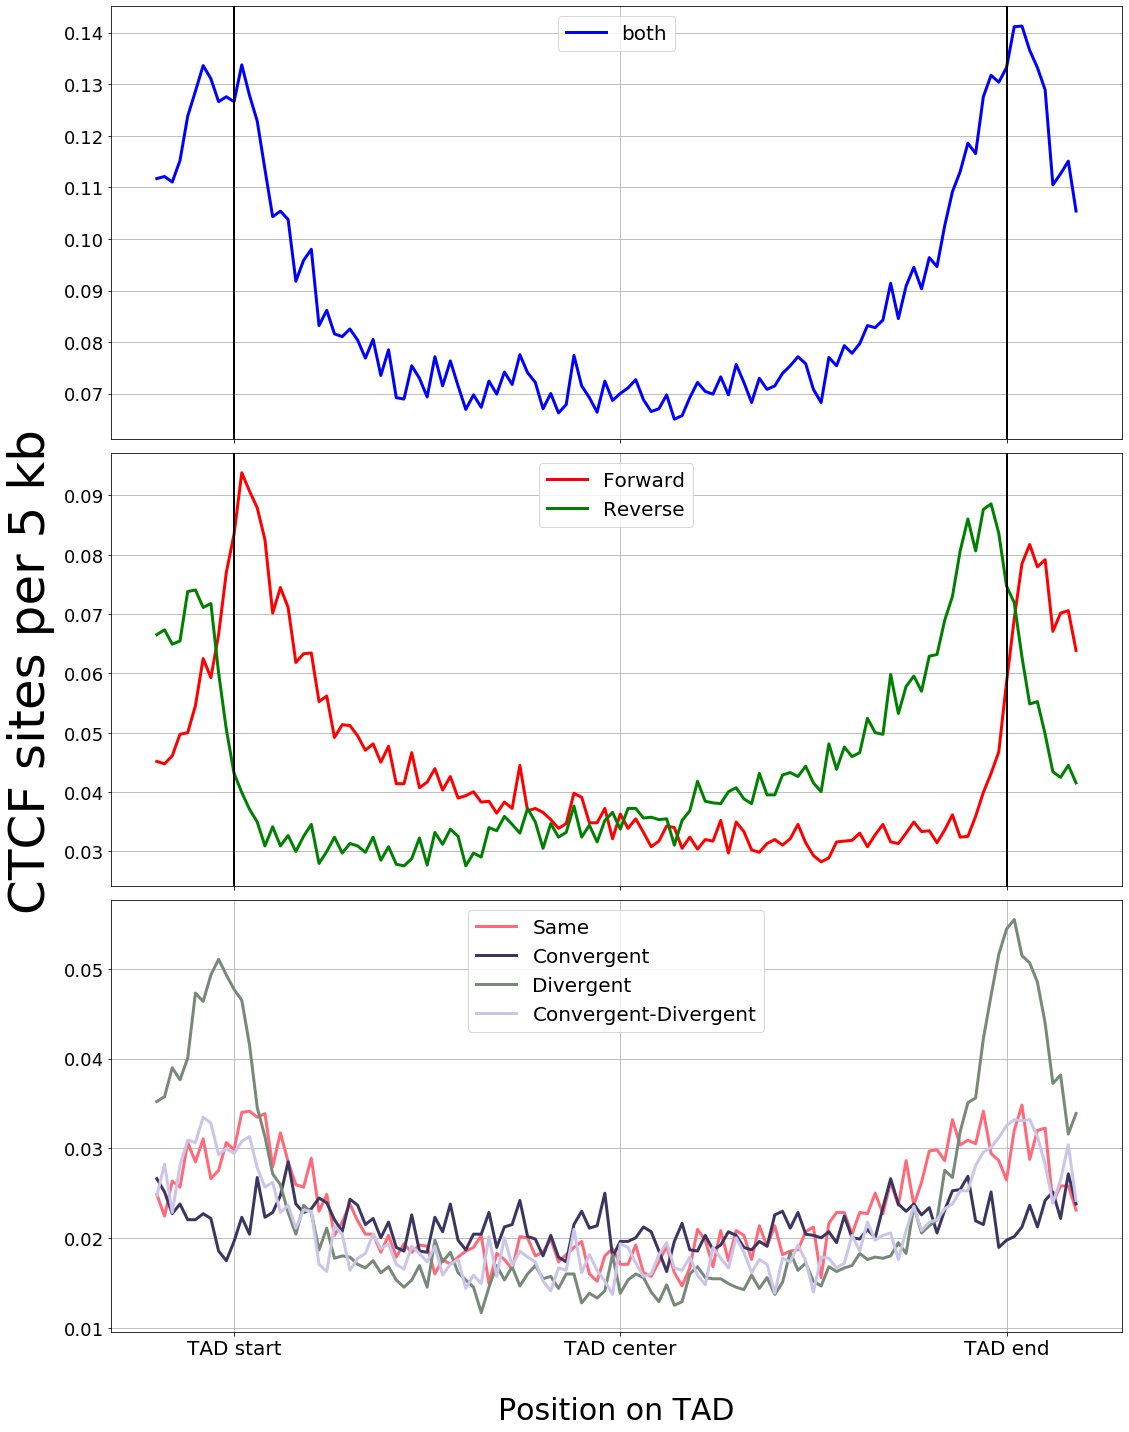

In [28]:
linewidth=3
legendfont = 20
labelfont = 30
tickfont = 20

fig, axes = plt.subplots(3,1,sharex=True,figsize=(15, 20))

axes[0].plot(aggregations_by_tad['ctcf_id'].mean(0), linewidth=linewidth, label='both', color='blue')
# axes[0].set_ylabel("CTCF sites per 5 kb\n", fontsize=labelfont)
axes[0].axvline(tad_start_window, color='black')
axes[0].axvline(tad_end_window, color='black')
axes[0].grid()
axes[0].legend(loc='upper center', fontsize=legendfont)

axes[1].plot(aggregations_by_tad['forward'].mean(0), linewidth=linewidth, label='Forward', color='red')
axes[1].plot(aggregations_by_tad['reverse'].mean(0), linewidth=linewidth, label='Reverse', color='green')
# axes[1].set_ylabel("CTCF sites per 5 kb\n", fontsize=60)
axes[1].axvline(tad_start_window, color='black')
axes[1].axvline(tad_end_window, color='black')
axes[1].grid()
axes[1].legend(loc='upper center', fontsize=legendfont)

axes[2].plot(aggregations_by_tad['S'].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
axes[2].plot(aggregations_by_tad['C'].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
axes[2].plot(aggregations_by_tad['D'].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
axes[2].plot(aggregations_by_tad['CD'].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
# axes[2].set_ylabel("CTCF sites per 5 kb\n", fontsize=labelfont)
# axes[2].axvline(extension/resolution, color='black')
axes[2].grid()
axes[2].legend(loc='upper center', fontsize=legendfont)

axes[2].set_xticks([tad_start_window, int(tad_start_window + tad_end_window)/2 ,tad_end_window])
axes[2].set_xticklabels(['TAD start', 'TAD center', 'TAD end'], fontsize=tickfont)
axes[2].set_xlabel("\nPosition on TAD", fontsize=labelfont)
fig.text(x=-0.02, y=0.37, s='CTCF sites per 5 kb', fontsize=50, ha='center', rotation=90)
# plt.xticks([tad_start_window, int(tad_start_window + tad_end_window)/2 ,tad_end_window], 
#            labels=['TAD start', 'TAD center', 'TAD end'], fontsize=tickfont)
# plt.xlabel("\nPosition", fontsize=labelfont)
# fig.savefig(figure_path / "avg_ctcf_sites_on_tads_by_window.pdf", bbox_inches='tight', transparent=True)
plt.show()